In [126]:
''' Code from Haodong Qin
edited by Iulia Rusu 
'''

import sys, os #, re, glob, socket, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





In [145]:
#import sci-kit learn for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

### 1: Functions needed for geodesic projection

In [2]:
def Mobius_addition(x,y,c):

    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space

    top = (1 + 2*c* np.dot(x,y) + c* np.dot(y,y))*x + (1-c*np.dot(x,x))*y
    bottom = 1 + 2*c* np.dot(x,y) + c**2*np.dot(x,x)*np.dot(y,y)
    return top/bottom


def Mobius_scalarMulti(x,r,c):

    # scalar vector multiplication
    # x is a N-dim vector, c is the curvature of the hyperbolic space

    result = 1/np.sqrt(c)*np.tanh(r*np.arctanh(np.sqrt( c*np.dot(x,x) ))) * x/np.sqrt(np.dot(x,x))
    return result 


def Geodesic_distance(x,y,c):
    
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space
    direc_vector = Mobius_addition(-x,y,c)
    dist = 2/np.sqrt(c)*np.arctanh(np.sqrt(c * np.dot(direc_vector,direc_vector) ))

    return dist

def Geodesic_r(t,x,y,c):

    # find the position vector on the geodesic connecting two vectors x and y 
    # when t = 0, final_position = x
    # when t = 1, final_position = y
    direc_vector = Mobius_addition(-x,y,c)

    displace_vector = Mobius_scalarMulti(direc_vector,t,c)

    final_position = Mobius_addition(x,displace_vector,c)

    return final_position

def Geodesic_projection_OptFun(t,x,y,c,p):
    # Function that is needed to optimized to find the geometric projection t
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # geodesic is connecting x and y
    # p is some vector 

    r_geodesic = Geodesic_r(t,x,y,c)

    dist = Geodesic_distance(p,r_geodesic,c)

    return dist


def conformal_factor(x,c):
    # deformation of the mapping from linear to hyperbolic space at position x

    lambda_c_x = 2/(1-c*np.dot(x,x))
    return lambda_c_x

def logarithmic_map(x,y,c):

    # the logarithmic_map will map a position vector y onto the tangent space at x in a hyperbolic space with curvature c
    # logarithmic_map: position in hyperbolic space -> tangent vector in tangent space
    
    minus_x_plus_y = Mobius_addition(-x,y,c)

    length_minus_x_plus_y = np.sqrt(np.dot(minus_x_plus_y,minus_x_plus_y))

    prefactor = 2/np.sqrt(c)/conformal_factor(x,c)*np.arctanh(np.sqrt(c)*length_minus_x_plus_y) 

    tangent_vector = prefactor*minus_x_plus_y/length_minus_x_plus_y

    return tangent_vector

def exponential_map(x,v,c):

    # the exponential_map will map a tangent vector v in the tangent space at x to a position vector in hyperbolic space with curvature c
    # exponential_map: tangent vector in tangent space -> position in hyperbolic space

    # first mapping the tangent vector v in linear space to vector in hyperbolic space
    length_v = np.sqrt(np.dot(v,v))
    constant_1 = np.sqrt(c)*conformal_factor(x,c)*length_v/2
    v_hyp = np.tanh(constant_1)*v/length_v/np.sqrt(c)

    # position vector in hyperbolic space:
    position_vector = Mobius_addition(x,v_hyp,c)

    return position_vector


    

### 3: doing the geometric projection

In [3]:
def hyp_to_hyp_poincare(hyp):

    t = 1
    for coord_idx in hyp.columns:

        t = t + hyp[coord_idx]**2

    t = np.sqrt(t)

    hyp_geo = hyp.copy()

    for coord_idx in hyp_geo.columns:

        hyp_geo[coord_idx] =  hyp_geo[coord_idx]/(1+t)

    return hyp_geo


In [4]:
#access hyp_emb from different notebook
%store -r pcoords_AVA_RME_stim1 

In [5]:
pcoords_AVA_RME_stim1.shape

(58, 6)

In [6]:
%store -r stim_1_AVA_RME_labels

In [7]:
#  import your data as dataframe, make sure the columns only include coordinates in the hyperbolic space
df_data = pd.DataFrame(pcoords_AVA_RME_stim1)

# select the point where the tangent space is located, usually at the origin
reference_point_tangent_space =  np.zeros(df_data.shape[1])

In [8]:
# transform the coordinates from native to Poincare ball
hyp_poincare = hyp_to_hyp_poincare(df_data)

# constant, this is fixed, no change
c_hyperbolicSpace = 1

# calculate the tangent vector using logrithmic map
hyp_tangent = hyp_poincare.copy()

for i in range(hyp_poincare.shape[0]):
    current_position_hyp = np.squeeze(hyp_tangent.values[i])
    hyp_tangent.iloc[i] = logarithmic_map(reference_point_tangent_space,current_position_hyp,c_hyperbolicSpace)


In [9]:
hyp_tangent


,0,1,2,3,4,5
0,0.066764,0.295188,0.033766,0.116911,0.133954,-0.095224
1,0.086935,0.306673,-0.033910,0.119647,0.099395,-0.067508
2,0.040328,0.281092,0.086648,0.159438,0.103594,-0.091340
3,0.145154,0.293890,0.061309,0.126053,0.018659,-0.094347
4,0.040611,0.287581,0.082019,0.149241,0.111942,-0.082509
5,0.160569,0.225535,0.087017,0.218507,0.029093,0.077230
6,0.119186,0.227060,0.126583,0.215797,0.092304,0.054994
7,0.104730,0.290001,0.077226,0.146821,0.089435,-0.064462
8,0.142913,0.293234,0.059613,0.129388,0.025276,-0.092393
9,0.110795,0.298917,0.001290,0.137521,0.098937,-0.066570


In [10]:
stim_1_AVA_RME_labels_array = np.array(stim_1_AVA_RME_labels)

In [11]:
data = pd.concat([hyp_tangent,stim_1_AVA_RME_labels ], axis =1 )

In [12]:
%store -r clust_labs_AVA_RME_stim1

In [52]:
clust_labs_AVA_RME_stim1 = np.array(clust_labs_AVA_RME_stim1)

In [54]:
clust_labs_AVA_RME_stim1.shape

(58,)

In [14]:
data['identity'] = clust_labs_AVA_RME_stim1

In [15]:
data

,0,1,2,3,4,5,worm_id,stim_group,OriginalIndex,identity
0,0.066764,0.295188,0.033766,0.116911,0.133954,-0.095224,4,1,540,RME
1,0.086935,0.306673,-0.033910,0.119647,0.099395,-0.067508,4,1,541,RME
2,0.040328,0.281092,0.086648,0.159438,0.103594,-0.091340,4,1,543,RME
3,0.145154,0.293890,0.061309,0.126053,0.018659,-0.094347,4,1,546,RME
4,0.040611,0.287581,0.082019,0.149241,0.111942,-0.082509,4,1,555,RME
5,0.160569,0.225535,0.087017,0.218507,0.029093,0.077230,4,1,557,RME
6,0.119186,0.227060,0.126583,0.215797,0.092304,0.054994,4,1,569,RME
7,0.104730,0.290001,0.077226,0.146821,0.089435,-0.064462,4,1,577,RME
8,0.142913,0.293234,0.059613,0.129388,0.025276,-0.092393,4,1,583,RME
9,0.110795,0.298917,0.001290,0.137521,0.098937,-0.066570,4,1,590,RME


In [16]:
# ON_means= np.mean(data.values[0:29, :], axis = 0)
#caluclate means 

RME_means = data[data['identity'] == 'RME'].iloc[:, 0:6].mean(axis=0)

In [17]:
RME_means = np.array(RME_means)

In [18]:
AVA_means = data[data['identity'] == 'AVA'].iloc[:, 0:6].mean(axis=0)

In [19]:
AVA_means = np.array(AVA_means)

In [21]:
#subtract ON from OFF
diff_means = RME_means[0:5] - AVA_means[0:5]

In [22]:
#normalize the difference
normalized = diff_means/np.linalg.norm(diff_means)

In [23]:
normalized

array([-0.45810578,  0.07499939, -0.76917521,  0.1787191 , -0.40117723])

In [24]:
axis_trans = np.dot(data.values[:, 0:5], normalized)

In [25]:
axis_trans.shape

(58,)

In [47]:
clust_labs_AVA_RME_stim1

array(['RME', 'RME', 'RME', 'RME', 'RME', 'RME', 'RME', 'RME', 'RME',
       'RME', 'RME', 'AVA', 'AVA', 'AVA', 'AVA', 'AVA', 'AVA', 'AVA',
       'AVA', 'AVA', 'AVA', 'AVA', 'AVA', 'RME', 'RME', 'RME', 'RME',
       'RME', 'RME', 'RME', 'RME', 'RME', 'RME', 'RME', 'RME', 'AVA',
       'AVA', 'AVA', 'AVA', 'AVA', 'RME', 'RME', 'RME', 'RME', 'AVA',
       'AVA', 'AVA', 'AVA', 'AVA', 'AVA', 'AVA', 'RME', 'RME', 'RME',
       'RME', 'AVA', 'AVA', 'AVA'], dtype='<U3')

In [65]:
clust_labs_AVA_RME_stim1.shape

(58,)

In [67]:
clust_labs_reshaped = clust_labs_AVA_RME_stim1[:, np.newaxis]
clust_labs_reshaped.shape

(58, 1)

In [74]:
axis_trans_reshaped = axis_trans[:, np.newaxis]

In [75]:
combined_array = np.concatenate((axis_trans_reshaped, clust_labs_reshaped), axis=1)

In [83]:
axis_trans_df = pd.DataFrame(combined_array)

In [84]:
axis_trans_df

,0,1
0,-0.067263,RME
1,-0.009234,RME
2,-0.077106,RME
3,-0.076569,RME
4,-0.078359,RME
5,-0.096195,RME
6,-0.133398,RME
7,-0.095268,RME
8,-0.076346,RME
9,-0.044444,RME


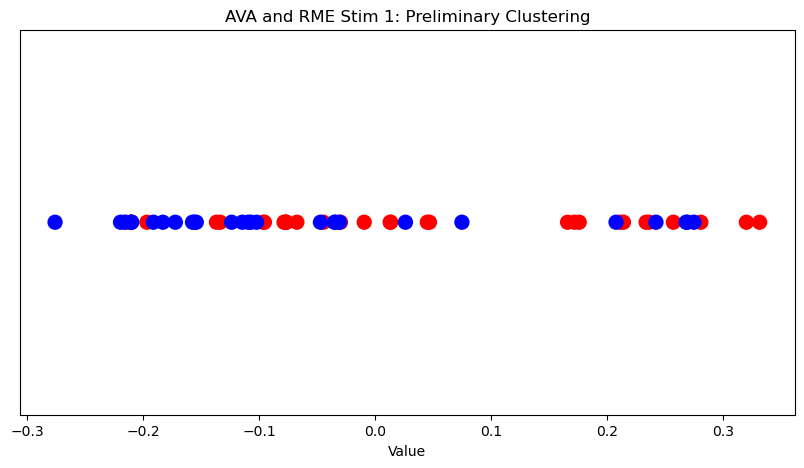

In [92]:
axis_trans_df.columns = ['Value', 'Category']

# Create a color map manually
color_map = {
    'RME': 'red',  # Color for 'RME'
    'AVA': 'blue'  # Color for 'AVA'
}

# Map labels to colors using the color map
label_colors = axis_trans_df['Category'].map(color_map)

# Create scatter plot with specified figure size
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(axis_trans_df['Value'], [0] * len(axis_trans_df), c=label_colors, s=100)
ax.set_xlabel('Value')
ax.yaxis.set_visible(False)
ax.set_title('AVA and RME Stim 1: Preliminary Clustering')

plt.show()


In [105]:
axis_trans_df

,Value,Category
0,-0.067263,RME
1,-0.009234,RME
2,-0.077106,RME
3,-0.076569,RME
4,-0.078359,RME
5,-0.096195,RME
6,-0.133398,RME
7,-0.095268,RME
8,-0.076346,RME
9,-0.044444,RME


In [107]:
RME = axis_trans_df[axis_trans_df['Category'] == 'RME']['Value']
AVA = axis_trans_df[axis_trans_df['Category'] == 'AVA']['Value']





In [116]:
RME

0    -0.067263
1    -0.009234
2    -0.077106
3    -0.076569
4    -0.078359
5    -0.096195
6    -0.133398
7    -0.095268
8    -0.076346
9    -0.044444
10   -0.136575
23    0.171947
24    0.257243
25      0.2364
26     0.21141
27    0.320159
28    0.176062
29    0.233742
30    0.166063
31    0.331578
32    0.280944
33     0.04702
34    0.214209
40   -0.210085
41   -0.196543
42   -0.209881
43   -0.214382
51    0.013112
52    0.045166
53   -0.029674
54    0.013595
Name: Value, dtype: object

(array([[0., 0., 4., 0., 2., 2., 5., 1., 2., 2., 2., 0., 0., 0., 3., 0.,
         4., 1., 1., 2.],
        [1., 2., 3., 4., 1., 5., 0., 3., 1., 1., 0., 1., 0., 0., 0., 1.,
         0., 3., 1., 0.]]),
 array([-0.27570497, -0.24534084, -0.2149767 , -0.18461256, -0.15424842,
        -0.12388428, -0.09352014, -0.06315601, -0.03279187, -0.00242773,
         0.02793641,  0.05830055,  0.08866469,  0.11902882,  0.14939296,
         0.1797571 ,  0.21012124,  0.24048538,  0.27084952,  0.30121365,
         0.33157779]),
 <a list of 2 list[Polygon] objects>)

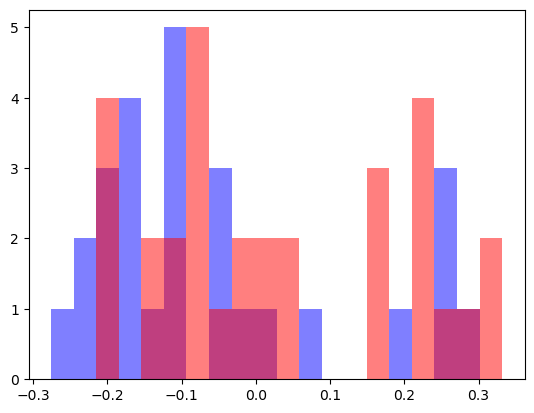

In [131]:
plt.hist([RME, AVA], bins = 20, alpha=0.5, label=['RME', 'AVA'], color = [ 'red','blue'], histtype='stepfilled')


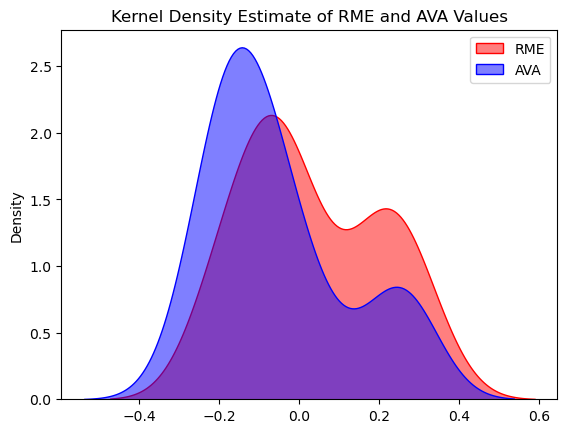

In [130]:
# Plotting KDE for each category
sns.kdeplot(RME, color='red', fill=True, alpha=0.5, label='RME')
sns.kdeplot(AVA, color='blue', fill=True, alpha=0.5, label='AVA')

# Adding labels and title
plt.xlabel('')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of RME and AVA Values')
plt.legend()

# Show the plot
plt.show()

#what should the x-axis be?

In [ ]:
#look at distance between distributions, KS distance 

In [136]:
#use svm in 8 dim space 
#also try a logistic regression, using 8 dim tangent space data and correspoding labels
#try MNE on tangent space coords
y = data.iloc[:, -1]
X = data.iloc[:, 0:5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [138]:
logreg = LogisticRegression(random_state=16)

# Train the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [139]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [140]:
y_pred = logreg.predict(X_test)

In [141]:
y_pred

array(['RME', 'RME', 'AVA', 'RME', 'AVA', 'AVA', 'AVA', 'AVA', 'AVA',
       'AVA', 'AVA', 'AVA', 'RME', 'AVA', 'RME'], dtype=object)

In [143]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4, 1],
       [6, 4]])

NameError: name 'Text' is not defined

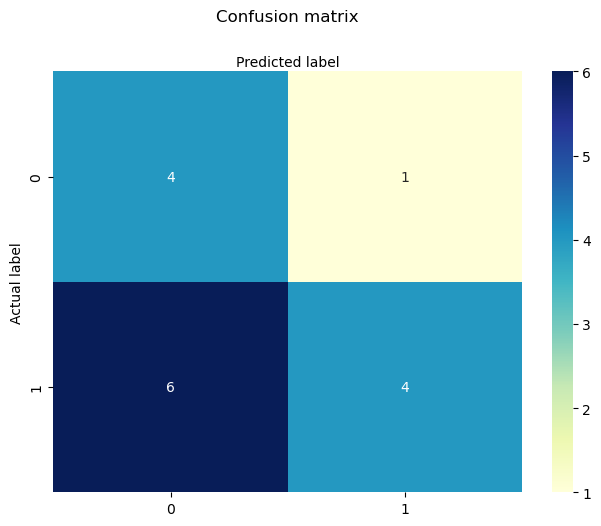

In [144]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,257.44,'Predicted label');

In [149]:
target_names = ['AVA', 'RME']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         AVA       0.40      0.80      0.53         5
         RME       0.80      0.40      0.53        10

    accuracy                           0.53        15
   macro avg       0.60      0.60      0.53        15
weighted avg       0.67      0.53      0.53        15

